In [1]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import math 
import os 

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.set(font='SimHei')

In [3]:
df= pd.read_csv('../dataset/min.csv')  # 读取股票文件

In [4]:
df.head()

,时间,开盘,收盘,最高,最低,成交量,成交额,最新价,code
0,2021-11-19 09:30:00,17.80,17.80,17.80,17.80,4127,7346060,17.80,1
1,2021-11-19 09:30:00,19.01,19.01,19.01,19.01,1718,3265918,19.01,2
2,2021-11-19 09:30:00,18.84,18.84,18.84,18.84,568,1070112,18.84,4
3,2021-11-19 09:30:00,4.12,4.12,4.12,4.12,29,11750,4.12,6
4,2021-11-19 09:30:00,2.14,2.14,2.14,2.14,165,35310,2.14,8


In [5]:
df = df.loc[df['code'] == 600000]
df.drop(['code'],axis=1,inplace=True)

In [6]:
df.set_index('时间',inplace=True)

In [7]:
df.head()

,开盘,收盘,最高,最低,成交量,成交额,最新价
时间,,,,,,,
2021-11-19 09:30:00,8.56,8.56,8.56,8.56,751,642856,8.560
2021-11-19 09:31:00,8.55,8.56,8.58,8.55,2536,2171176,8.562
2021-11-19 09:32:00,8.58,8.58,8.58,8.55,1127,965498,8.563
2021-11-19 09:33:00,8.58,8.57,8.58,8.56,433,371053,8.563
2021-11-19 09:34:00,8.57,8.58,8.58,8.57,1207,1034632,8.565


## 数据检查

In [8]:
# Function to check the missing percent of a DatFrame;
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False) * 100 /len(df),2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [9]:
check_missing_data(df)

,Total,Percent
开盘,0,0.0
收盘,0,0.0
最高,0,0.0
最低,0,0.0
成交量,0,0.0
成交额,0,0.0
最新价,0,0.0


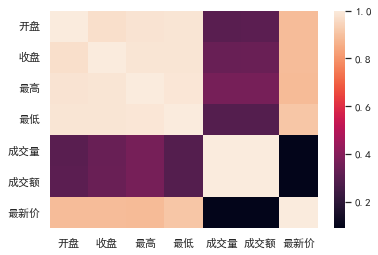

In [10]:
sns.heatmap(df.corr())
plt.show()

In [11]:
#获取DataFrame中的数据，形式为数组array形式
values=df.values
#确保所有数据为float类型
values=values.astype('float32')
 
# 特征的归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.06666946 0.06666946 0.         ... 0.06737782 0.06687932 0.        ]
 [0.         0.06666946 0.1428566  ... 0.230124   0.22846356 0.03077698]
 [0.20000076 0.20000076 0.1428566  ... 0.10165937 0.1009912  0.04614258]
 ...
 [0.7333336  0.66666794 0.7142868  ... 0.03501094 0.03515772 0.98461914]
 [0.66666794 0.66666794 0.7142868  ... 0.29385483 0.29475513 0.98461914]
 [0.66666794 0.66666794 0.6428566  ... 0.15007295 0.15049942 1.        ]]


In [12]:
# 定义series_to_supervised()函数
# 将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    将时间序列框定为有监督的学习数据集。
        论据：
        数据：作为列表或NumPy数组的观察序列。
        n_in：作为输入的滞后观测数（X）。
        n_out：作为输出的观察数（y）。
        dropnan：布尔值，决定是否删除具有NaN值的行。
    返回：
    pd.DataFrame(用于监督学习)
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
#将时间序列转换为监督学习问题
reframed = series_to_supervised(scaled, 1, 1)

In [14]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.066669,0.066669,0.000000,0.071430,0.067378,0.066879,0.000000,0.000000,0.066669,0.142857,0.000000,0.230124,0.228464,0.030777
2,0.000000,0.066669,0.142857,0.000000,0.230124,0.228464,0.030777,0.200001,0.200001,0.142857,0.000000,0.101659,0.100991,0.046143
3,0.200001,0.200001,0.142857,0.000000,0.101659,0.100991,0.046143,0.200001,0.133331,0.142857,0.071430,0.038384,0.038142,0.046143
4,0.200001,0.133331,0.142857,0.071430,0.038384,0.038142,0.046143,0.133331,0.200001,0.142857,0.142857,0.108953,0.108301,0.076920
5,0.133331,0.200001,0.142857,0.142857,0.108953,0.108301,0.076920,0.200001,0.200001,0.214287,0.142857,0.146335,0.145592,0.123077


In [15]:
# 删除不想预测的特征列，这里只预测收盘价
# 所以删除的是var1(t),var2(t),var3(t),
reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)','var6(t)'], axis=1, inplace=True)
# 打印数据的前5行
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.066669,0.066669,0.000000,0.071430,0.067378,0.066879,0.000000,0.030777
2,0.000000,0.066669,0.142857,0.000000,0.230124,0.228464,0.030777,0.046143
3,0.200001,0.200001,0.142857,0.000000,0.101659,0.100991,0.046143,0.046143
4,0.200001,0.133331,0.142857,0.071430,0.038384,0.038142,0.046143,0.076920
5,0.133331,0.200001,0.142857,0.142857,0.108953,0.108301,0.076920,0.123077


## 数据划分为训练集和测试集：

* 将处理后的数据集划分为训练集和测试集。这里按0.85比例划分，将训练集和测试集的最终输入（X）转换为为LSTM的输入格式，即[samples,timesteps,features]。

* Keras LSTM层的工作方式是通过接收3维（N，W，F）的数字阵列，其中N是训练序列的数目，W是序列长度，F是每个序列的特征数目。


In [16]:
# 划分训练集和测试集
train = reframed.iloc[:int(len(reframed)*0.85),:].values
test = reframed.iloc[int(len(reframed)*0.85):,:].values
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(201, 1, 7) (201,)
(36, 1, 7) (36,)


# 模型构建及其预测

* 搭建LSTM模型并绘制损失图
    * 本实验使用keras深度学习框架对模型进行快速搭建。建立Sequential模型，向其中添加LSTM层，设定Dropout为0.5，加入Dense层将其维度聚合为1，激活函数使用relu（也用了sigmoid作为激活函数，但实验效果不如relu），损失函数定为均方差Mean Absolute Error(MAE)。优化算法采用Adam，模型采用50个epochs并且每个batch的大小为100。其中：隐藏层有64个神经元，输出层1个神经元（回归问题），输入变量是一个时间步（t-1）的特征。在fit()函数中设置validation_data参数，记录训练集和测试集的损失。

### 预测一次，并保存预测结构，用于之后的验证

In [17]:
checkpoint_save_path = "./checkpoint/test_4_1.ckpt"

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

* LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq)
* Dropout(dropout_rate)
* Dense(neurons, activation=activation)

In [19]:
train_X.shape[1], train_X.shape[2]

(1, 7)

Epoch 1/50
3/3 - 9s - loss: 0.4227 - val_loss: 0.9444 - 9s/epoch - 3s/step
Epoch 2/50
3/3 - 0s - loss: 0.4064 - val_loss: 0.9226 - 149ms/epoch - 50ms/step
Epoch 3/50
3/3 - 0s - loss: 0.3883 - val_loss: 0.8958 - 156ms/epoch - 52ms/step
Epoch 4/50
3/3 - 0s - loss: 0.3664 - val_loss: 0.8615 - 142ms/epoch - 47ms/step
Epoch 5/50
3/3 - 0s - loss: 0.3399 - val_loss: 0.8166 - 155ms/epoch - 52ms/step
Epoch 6/50
3/3 - 0s - loss: 0.3060 - val_loss: 0.7565 - 131ms/epoch - 44ms/step
Epoch 7/50
3/3 - 0s - loss: 0.2636 - val_loss: 0.6754 - 160ms/epoch - 53ms/step
Epoch 8/50
3/3 - 1s - loss: 0.2085 - val_loss: 0.5651 - 537ms/epoch - 179ms/step
Epoch 9/50
3/3 - 0s - loss: 0.1354 - val_loss: 0.4145 - 161ms/epoch - 54ms/step
Epoch 10/50
3/3 - 0s - loss: 0.0745 - val_loss: 0.2375 - 149ms/epoch - 50ms/step
Epoch 11/50
3/3 - 0s - loss: 0.1044 - val_loss: 0.0818 - 157ms/epoch - 52ms/step
Epoch 12/50
3/3 - 0s - loss: 0.1622 - val_loss: 0.0268 - 163ms/epoch - 54ms/step
Epoch 13/50
3/3 - 0s - loss: 0.2126 - val

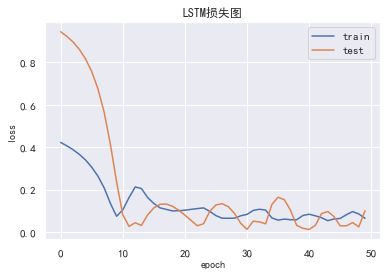

In [20]:
# 搭建LSTM模型
model = Sequential()

model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1,activation='relu'))

model.compile(loss='mae', optimizer='adam')

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)
    
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2,shuffle=False,
                    validation_freq=1,callbacks=[cp_callback])
 
# 绘制损失图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM损失图', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

* 预测并反转数据（反归一化）
    * 需要将预测结果和测试集数据组合然后进行比例反转（invert the scaling），同时需要将测试集上的预期值也进行比例转换。 
         这里为什么进行比例反转（反归一化）呢？（因为我们将原始数据进行了预处理（连同输出值y），此时的误差损失计算是在处理之后的数据上进行的，为了计算在原始比例上的误差需要将数据进行转化。反转时的矩阵大小一定要和原来的大小（shape）完全相同，否则就会报错。）

In [21]:
#模型预测收益率
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
 
# invert scaling for forecast
#将预测结果按比例反归一化
inv_y_test = np.concatenate((test_X[:, :6],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
# invert scaling for actual
#将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X[:, :6],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]

In [22]:
data = pd.DataFrame({"反归一化后的预测结果":inv_y_predict,'反归一化后的真实结果':inv_y})
data.head()

,反归一化后的预测结果,反归一化后的真实结果
0,8.615442,8.622
1,8.615470,8.622
2,8.615196,8.622
3,8.615523,8.622
4,8.615425,8.622


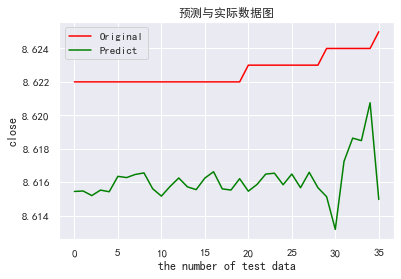

In [23]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close')
plt.title('预测与实际数据图')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 评估
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(inv_y_predict, inv_y)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(inv_y_predict, inv_y))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(inv_y_predict, inv_y)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.000045
均方根误差: 0.006684
平均绝对误差: 0.006559


In [25]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(inv_y_predict[i] - inv_y[i])
    summery += inv_y[i]
acc = 1 - error/summery
print("准确率：{}".format(acc))

准确率：0.9992715082431637
